### Phys 629, Fall 2023, University of Mississippi


# Lecture 20, Chapter 5: Bayesian Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.

***Exercises required for class participation are in <font color='red'>red</font>.***

## Markov Chain Monte Carlo (MCMC) Techniques <a class="anchor" id="two"></a>

> The use of **Markov chains** to perform **Monte Carlo integration** is called ***Markov Chain Monte Carlo (MCMC)***.

Given such a Markov chain of length $N$ that corresponds to draws of $p(\theta)$, integrals can be estimated as

$$ \int g(\theta) \, p(\theta) \, d\theta \approx {1 \over N} \sum_{i=1}^Ng(\theta_i).$$

- To estimate the expectation value for $\theta_1$ (i.e., $g(\theta)=\theta_1$), we simply take the mean value of all $\theta_1$ in the chain.
- To visualize the posterior pdf for parameter $\theta_1$, marginalized over all other parameters, $\theta_2, \ldots, \theta_k$, we can construct a histogram of all $\theta_1$ values in the chain, and normalize its integral
to 1. 
- To get a MAP (*maximum a posterori*) estimate for $\theta_1$, we find the maximum of this marginalized pdf.

In order for a Markov chain to reach a **stationary distribution** proportional to $p(\theta)$, the probability of arriving at a point $\theta_{i+1}$ must be proportional to $p(\theta_{i+1})$,

$$ p(\theta_{i+1}) = \int  T(\theta_{i+1}|\theta_i)  \,   p(\theta_i) \,    d \theta_i, $$

where the transition probability $T(\theta_{i+1}|\theta_i)$ is called the **proposal distribution** (and it is assumed that we know how to compute $p(\theta_i)$). The proposal distribution is exactly what it sounds like-- it proposes new positions to jump to in parameter space.

This requirement will be satisfied when the transition probability satisfies **the principle of detailed balance**

$$ T(\theta_{i+1}|\theta_i)  \,  p(\theta_i) = T(\theta_i|\theta_{i+1})  \,  p(\theta_{i+1}). $$

Most of the difficulty in MCMC comes from either determining the burn-in or deciding how to step from one position to another.  In our circle example above, we drew points in a completely random manner. However, that's sub-optimal. ***We want random sampling that preferentially steps into regions of high probability density.***  

The most commonly used algorithm for stepping from one position to another is the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm.  

## The Metropolis-Hastings Algorithm <a class="anchor" id="three"></a>

**The Metropolis-Hastings algorithm** adopts the following acceptance probability for newly proposed points to step to:

$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = { p(\theta_{i+1}) \over p(\theta_i) }, $$

where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $T(\theta_{i+1}\,|\,\theta_i)$. Since it is symmetric, the **ratio of transition probabilities cancels out and detailed balance is ensured**. A Gaussian distribution centered on the current point $\theta_i$ is often used for $T(\theta_{i+1}|\theta_i)$.

This algorithm guarantees that the chain will reach an equilibrium, or stationary distribution, and it will approximate a sample drawn from $p(\theta)$! 

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1. Given $\theta_i$ and $T(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ 
2. Compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.
3. Draw a random number between 0 and 1 from a uniform distribution; if it is smaller than $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$. 
4. ***If $\theta_{i+1}$ is accepted add it to the chain. If not, add $\theta_{i}$ to the chain.***
5. Use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for $\theta$ can be computed from 

  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{N} \sum_{i=1}^N g(\theta_i).$$

where N is the number of elements in the chain (e.g. the expectation value for $\theta$ is simply the mean value of chain elements). 

***Step 3*** is very important. If we only accepted points of higher probability then we would only move up the posterior density to find its maximum. But we want to map out the full posterior density, so sometimes we must settle for less!

### Corner Plots

If you are using MCMC, then you probably have multiple parameters (otherwise, you'd be doing something easier).  So, it helps to display the parameters two at a time, marginalizing over the other parameters.  An example is given in Ivezic, Figure 5.24, which compares the model results for a single Gaussian fit to a double Gaussian fit. These are called `corner` or `triangle` plots, which we've discussed before.

The most popular packages to make these are [corner](https://corner.readthedocs.io/en/latest/) and [chainconsumer](https://samreay.github.io/ChainConsumer/).

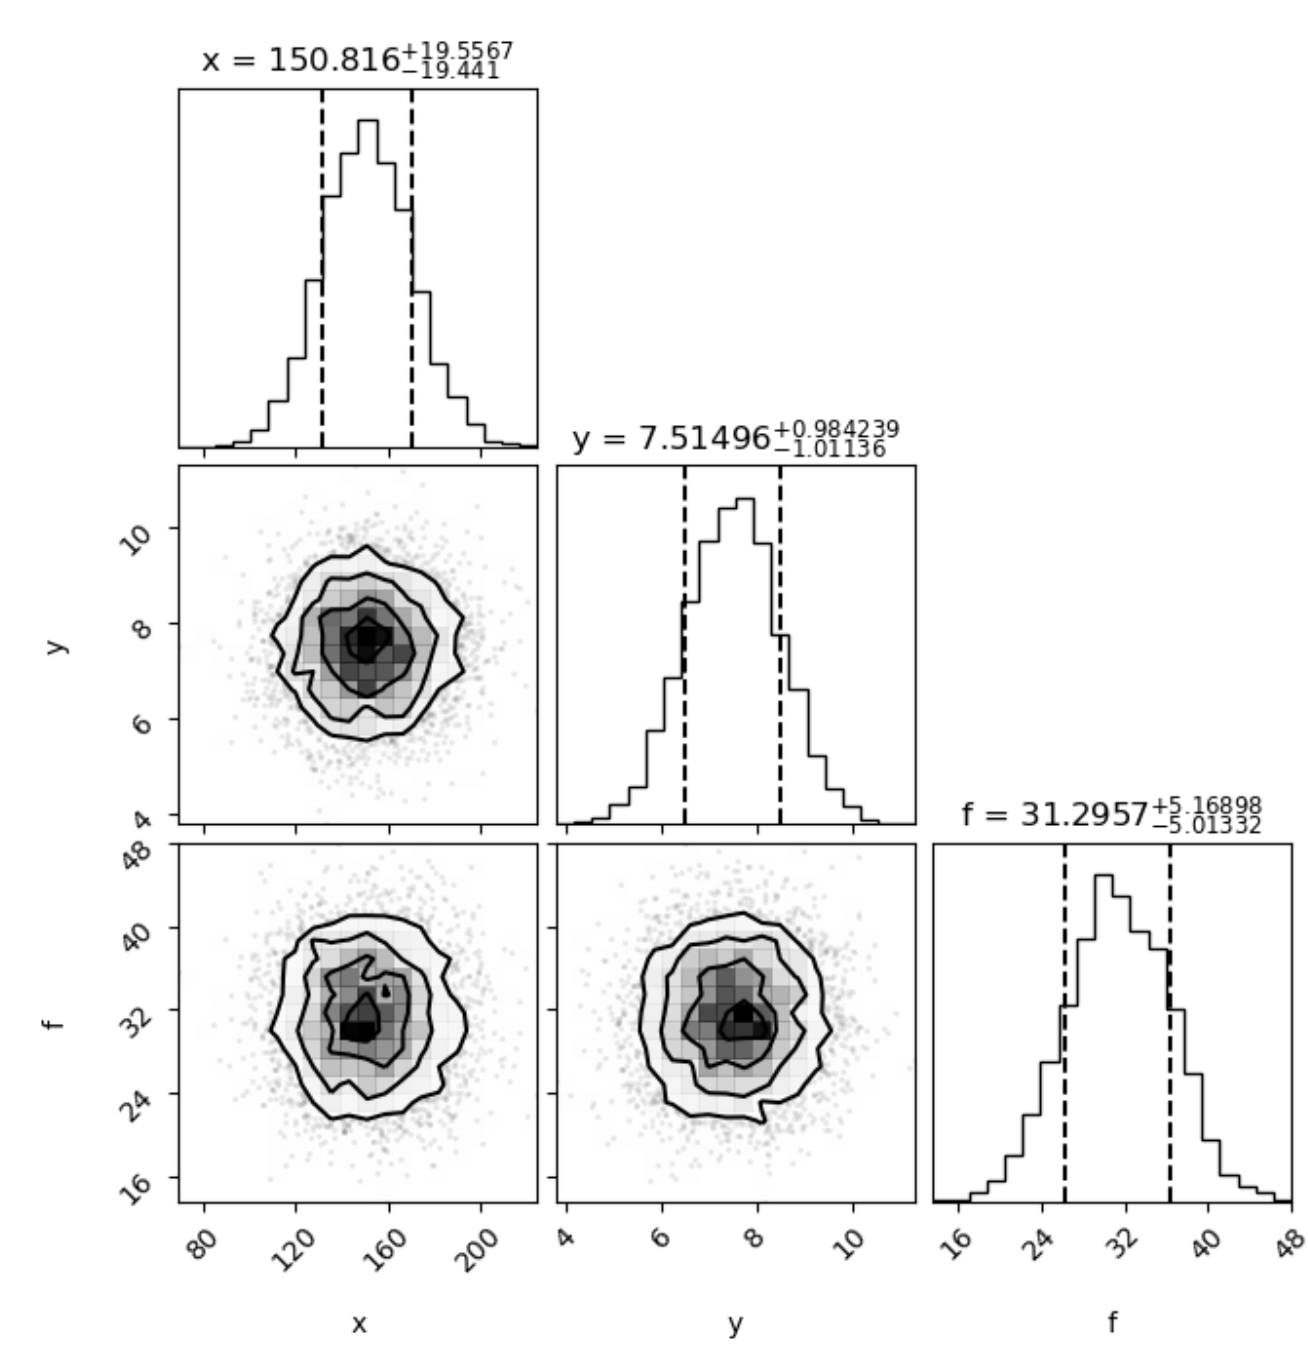

## Worked Example <a class="anchor" id="four"></a>

We'll now go through the example given at
[http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).

Let's generate some data points and plot them.  We'll try a normal distribution, centered at 0 with 100 data points, using [numpy.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html). Our goal is to estimate $\mu$.

Text(0.5, 1.0, 'Data pdf- Normal Distribution')

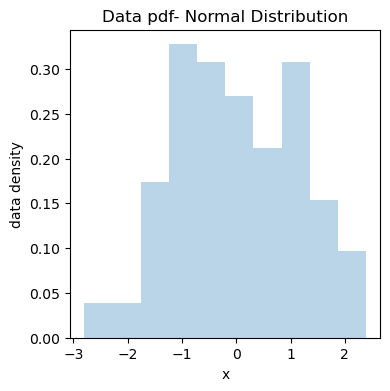

In [1]:
import scipy as sp
import pandas as pd
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(123)

data = np.random.randn(100) # mean 0 variance 1
plt.figure(figsize=(4,4))
plt.hist(data, bins=10, density=True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('data density')
plt.title('Data pdf- Normal Distribution')

Now we have to pick a model.

- We'll assume a Gaussian likelihood distribution: $\mathscr{N}(\mu,\sigma=1)$ (i.e., with $\sigma=1$).  
- We'll also assume a Gaussian distribution for the prior on $\mu$: $\mathscr{N}(0,1)$.

We can use that to write an analytic function for our posterior distribution as follows (*recalling that the product of two Gaussians is also a Gaussian*):

Text(0.5, 1.0, 'Not normalized Posteroir')

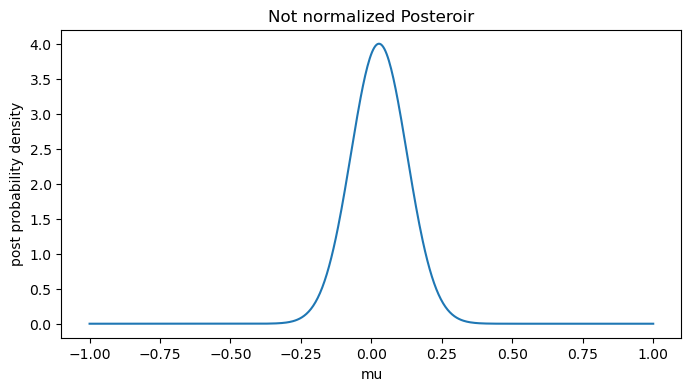

In [2]:
# Execute this cell
def calc_posterior_analytical(data, xgrid, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    
    # Error-weighted sum of prior and average of data
    # Recall the product of 2 Gaussians
    
    # This is the Gaussian MLE estimate for the prior: mu_0 / sigma_0**2
    # This is the Gaussian MLE estimate for the likelihood: data.sum() / sigma**2
    # We are deriving the mean from the sum of the data values
    
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    var_post = (1. / sigma_0**2 + n / sigma**2)**-1
    
    return norm.pdf(xgrid, mu_post, np.sqrt(var_post))

plt.figure(figsize=(8,4))
xgrid = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, xgrid, 0., 1.)
plt.plot(xgrid, posterior_analytical)
plt.xlabel('mu')
plt.ylabel('post probability density')
plt.title('Not normalized Posteroir')

#### Let's try this instead with MCMC. 

- We'll start with a trial $\mu_0 = -1$ and evaluate.
- Then we'll jump to a new position using the Metropolis-Hastings algorithm mentioned above.  
- Next we evaluate whether that jump was "good" or not -- by seeing if the value of the likelihood $\times$ prior increases.  

*We always work with the un-normalized posterior (i.e. likelihood $\times$ prior) in these MCMC algorithms (or equivalently the un-normalized log-posterior which equals log-likelihood + log-prior).*

<font color='red'>Read through the first function below to understand how it is implementing the Metropolis-Hastings algorithm. But don't worry about the second function, which is just setting up plots.</font>

In [3]:
## Execute this cell
## See https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb
def sampler(data, samples=4, mu_init=.5, proposal_width=0.5, 
            plot=False, mu_prior_mu=0, mu_prior_sd=1.): # Takes 4 samples, initial guess, proposed width
    mu_current = mu_init
    posterior = [mu_current] # Updates mu_current every time
    for i in range(samples):
        # suggest new position
        # changing the width of this distribution changes how big the jump is between trials.
        mu_proposal = norm(mu_current, proposal_width).rvs() # Theta_i+1 to be accepted or rejected

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod() #Theta_i likelihood
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod() #Theta_i+1 likelihood
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current) #Theta_i prior
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal) #Theta_i+1 prior
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current # Metropolis-Hastings
        
        # Usually would include prior probability, which we neglect here for simplicity
        # Accept if p_accept > 1 (since random limited to [0,1]) and if p_accept > rand as well
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, 
                          mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

## Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, 
                  mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    xgrid = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm.pdf(xgrid,mu_prior_mu, mu_prior_sd)
    ax1.plot(xgrid, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', 
            title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, 
                                                                                       prior_current, 
                                                                                       mu_proposal, 
                                                                                       prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm.pdf(xgrid,loc=mu_proposal, scale=1)
    
    ax2.hist(data,alpha=0.5,density='True')
    ax2.plot(xgrid, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 
                                                                              1e14*likelihood_current, 
                                                                              mu_proposal, 
                                                                              1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, xgrid, 
                                                     mu_prior_mu, 
                                                     mu_prior_sd)
    ax3.plot(xgrid, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, 
                                                  mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, 
                                                   mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, 
                                                                            posterior_current, 
                                                                            mu_proposal, 
                                                                            posterior_proposal)) 
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

Each row below is a single iteration through our Metropolis-Hastings sampler.

- **1st column = prior distribution**. The distribution is static and we are only plugging in our $\mu$ proposals. The vertical lines represent the current $\mu$ in blue and the proposed $\mu$ in either red or green (rejected or accepted, respectively).


- **2nd column = likelihood**.  The likelihood function changes in response to the proposed $\mu$. The blue histogram is the data. The solid line in green or red is the likelihood with the currently proposed mu. The more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dashed line of the same color is the proposed mu and the dashed blue line is the current mu.


- **3rd column = (normalized) posterior distribution**.


- **4th column = trace** (i.e. the posterior samples of $\mu$ we are generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values

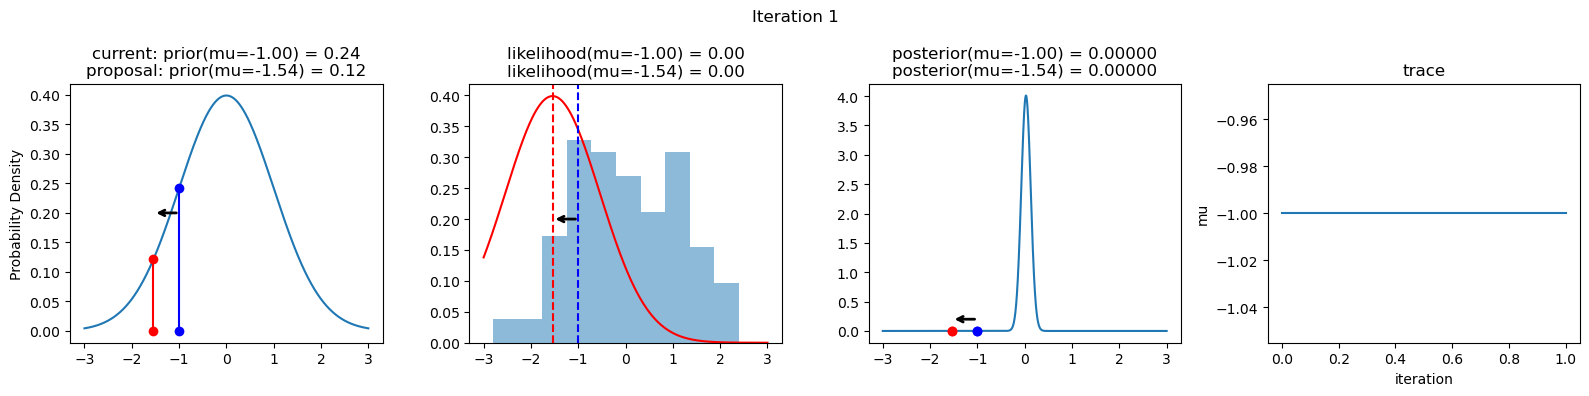

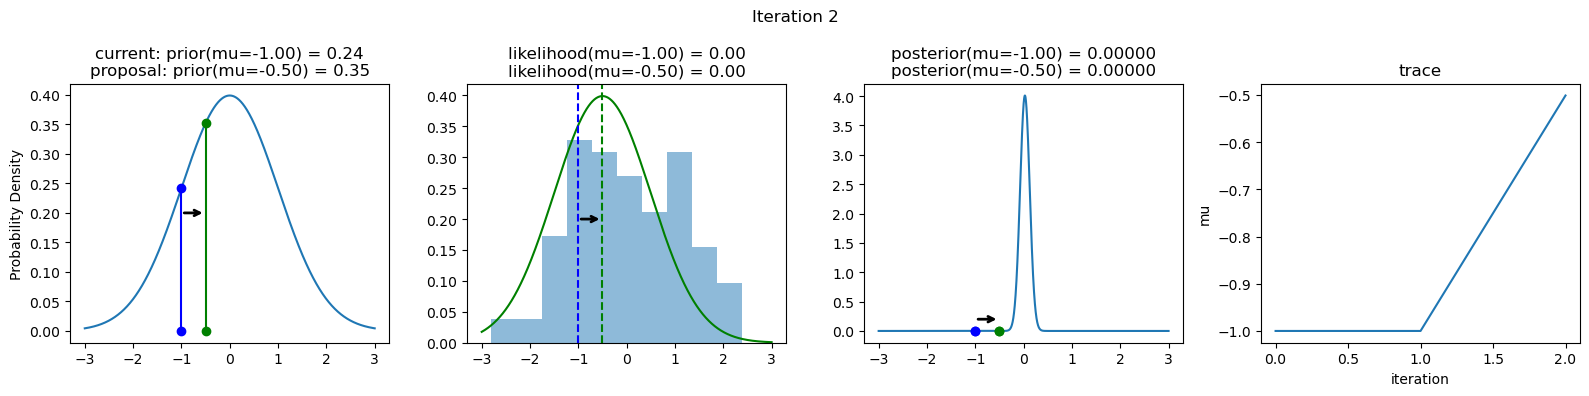

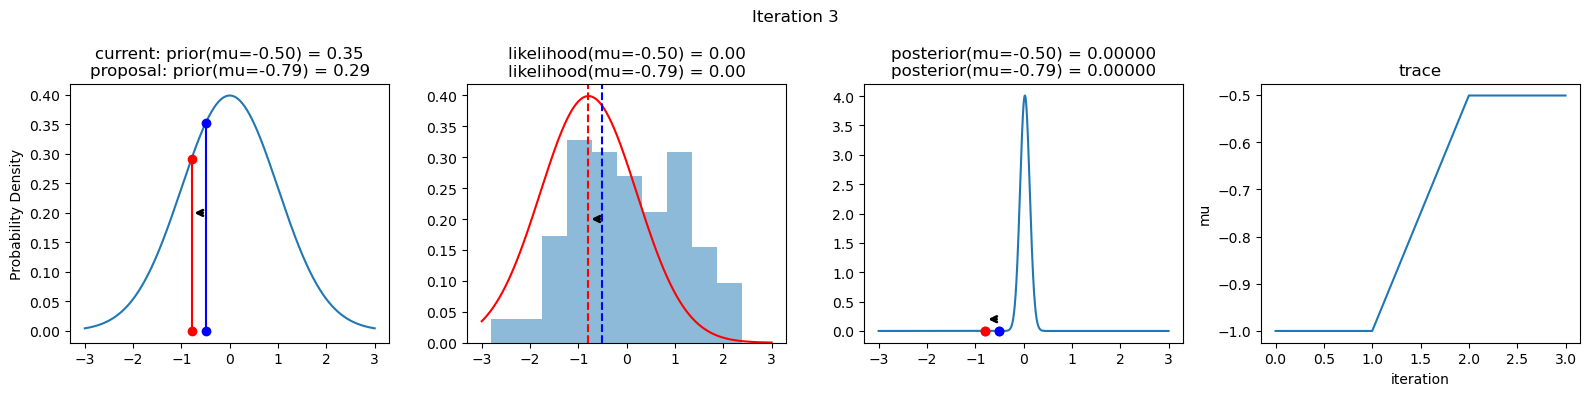

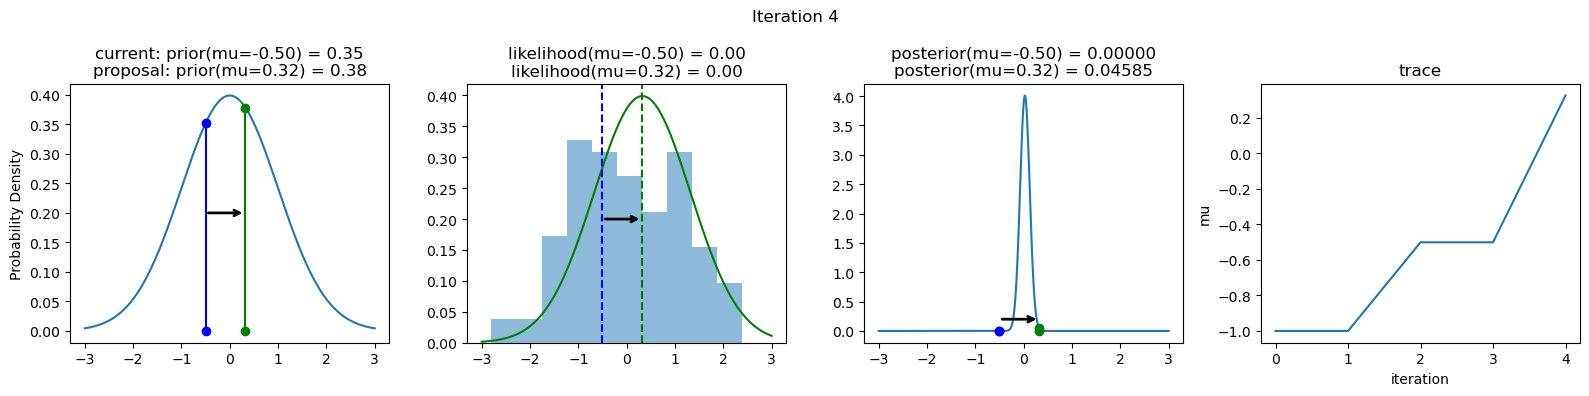

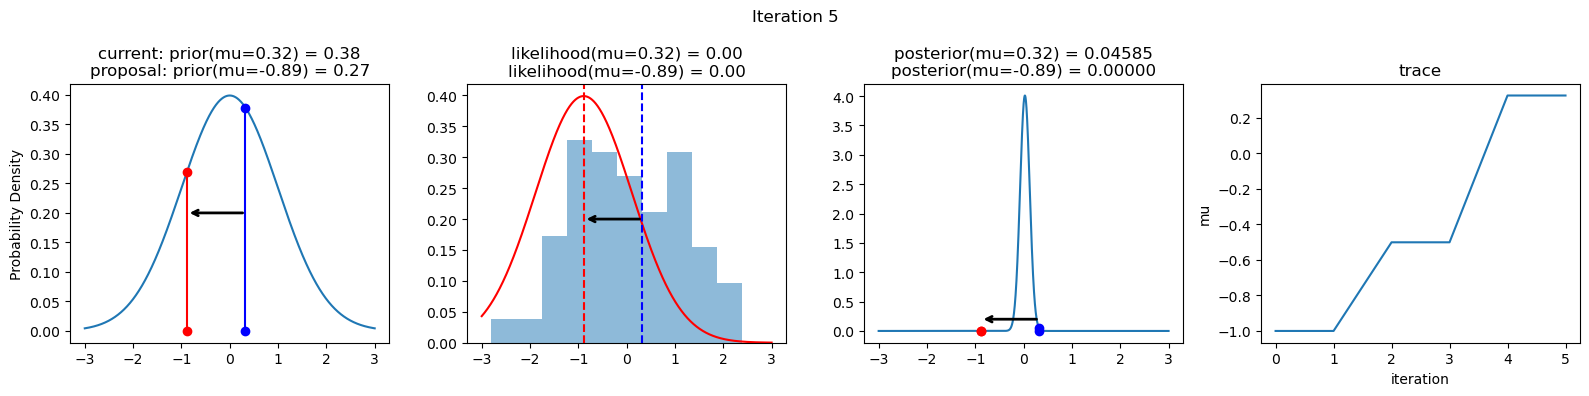

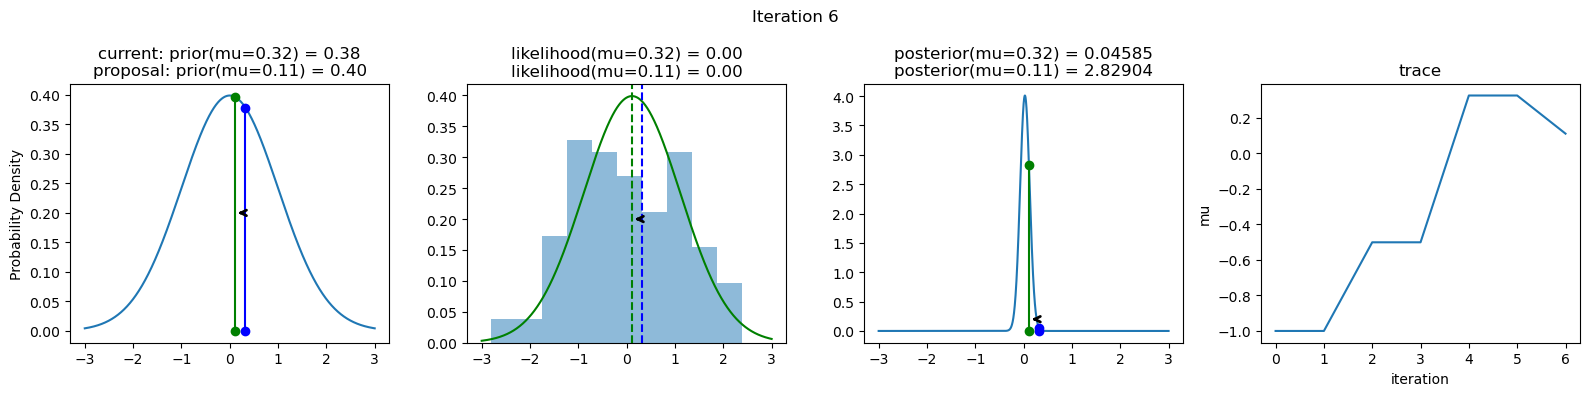

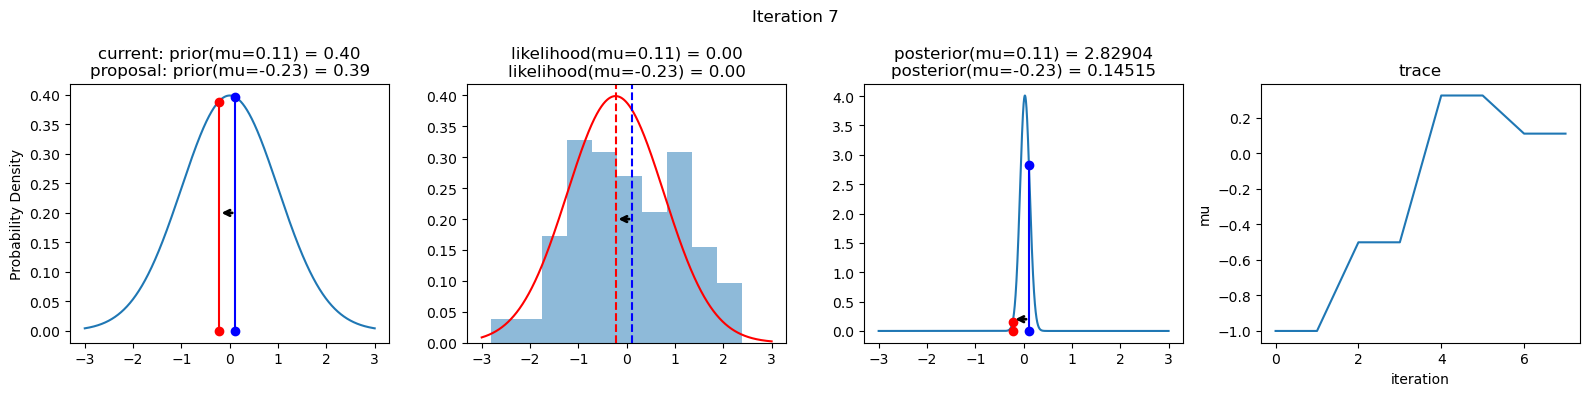

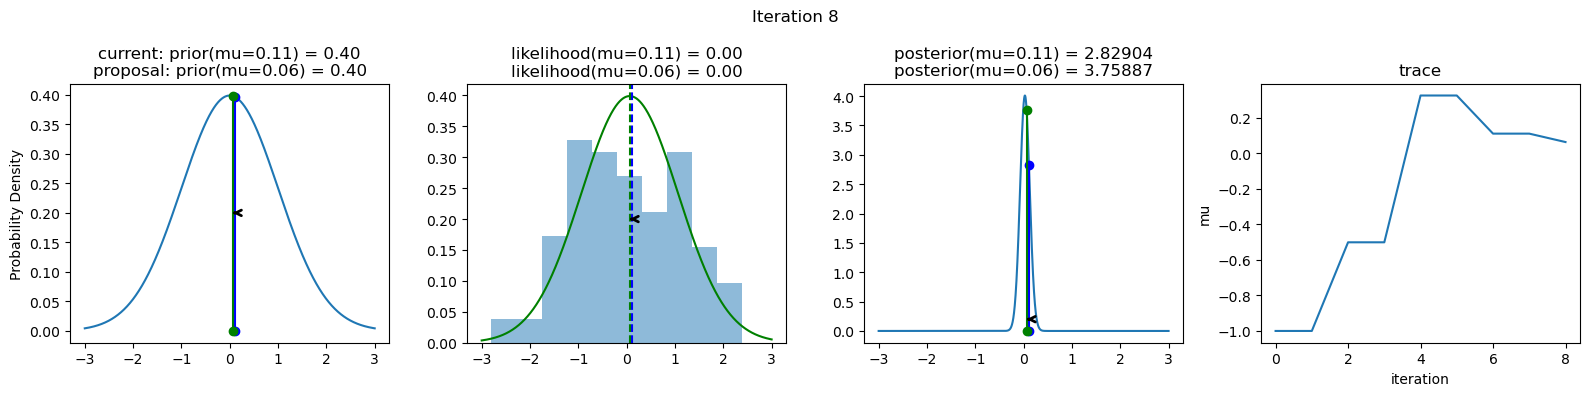

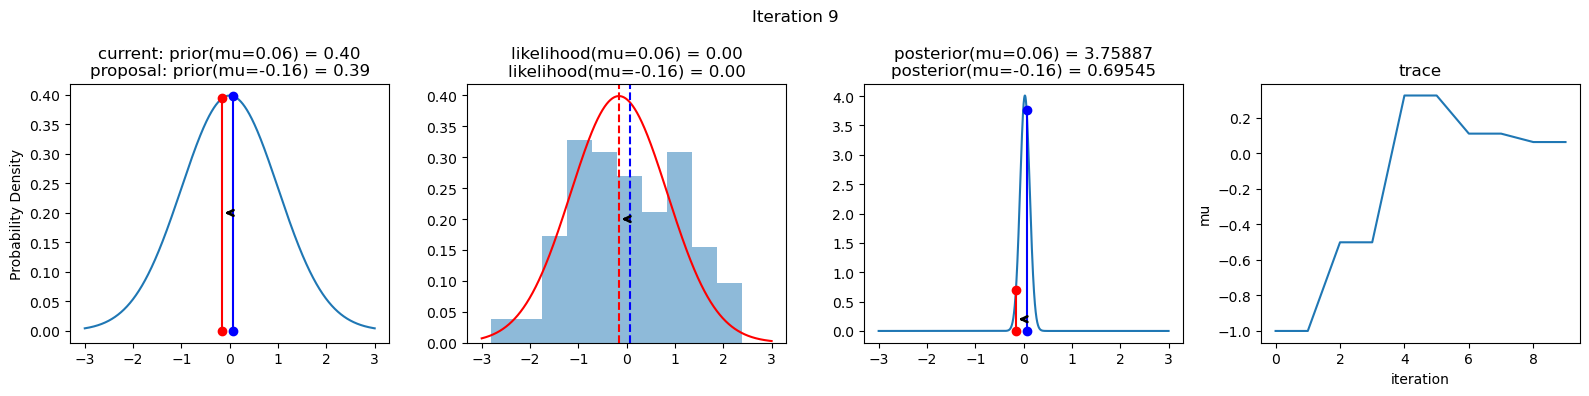

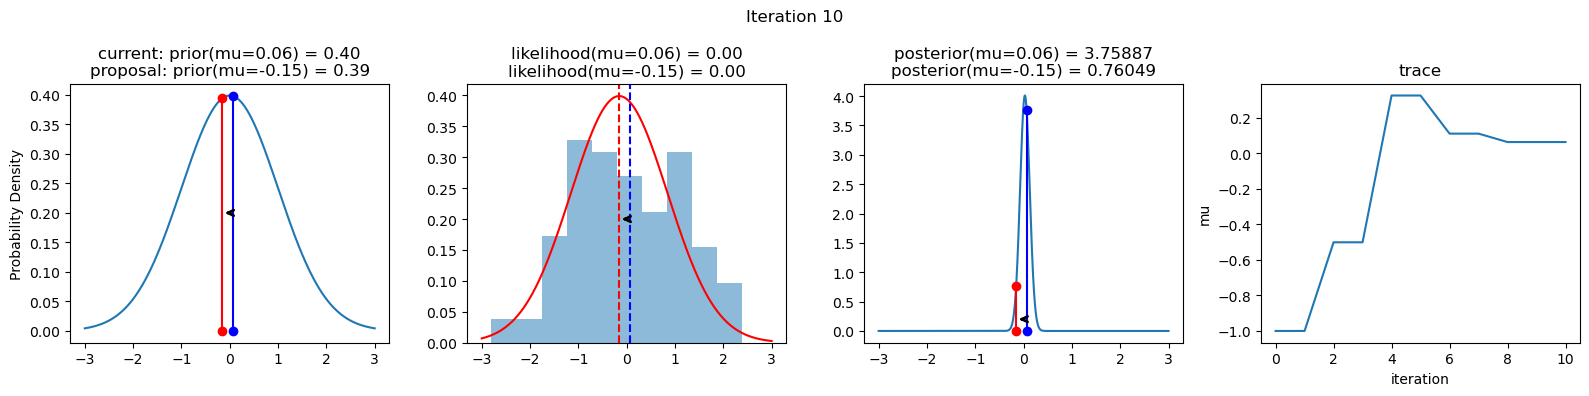

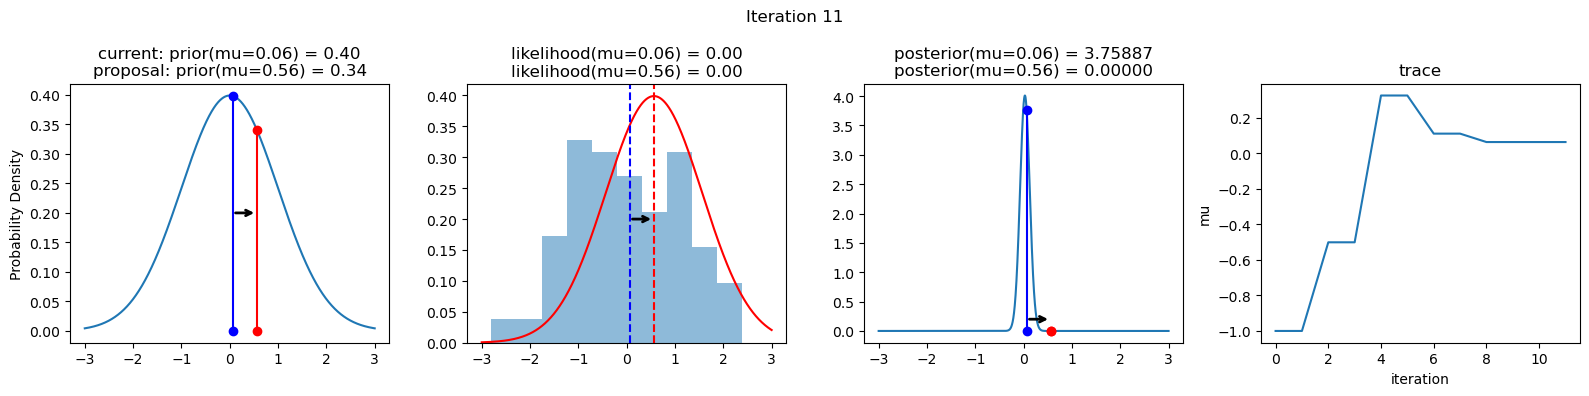

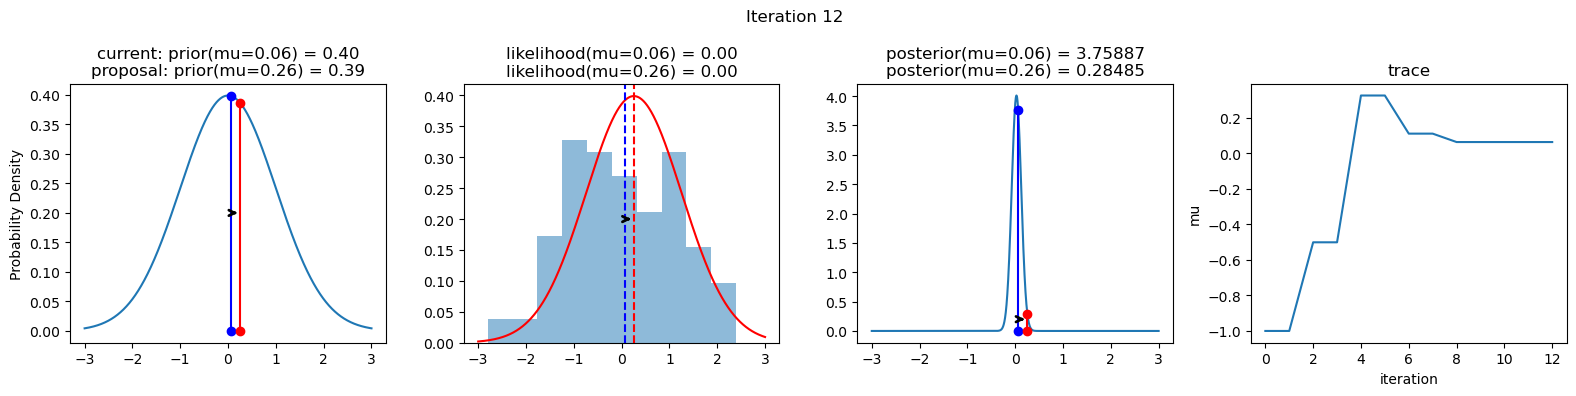

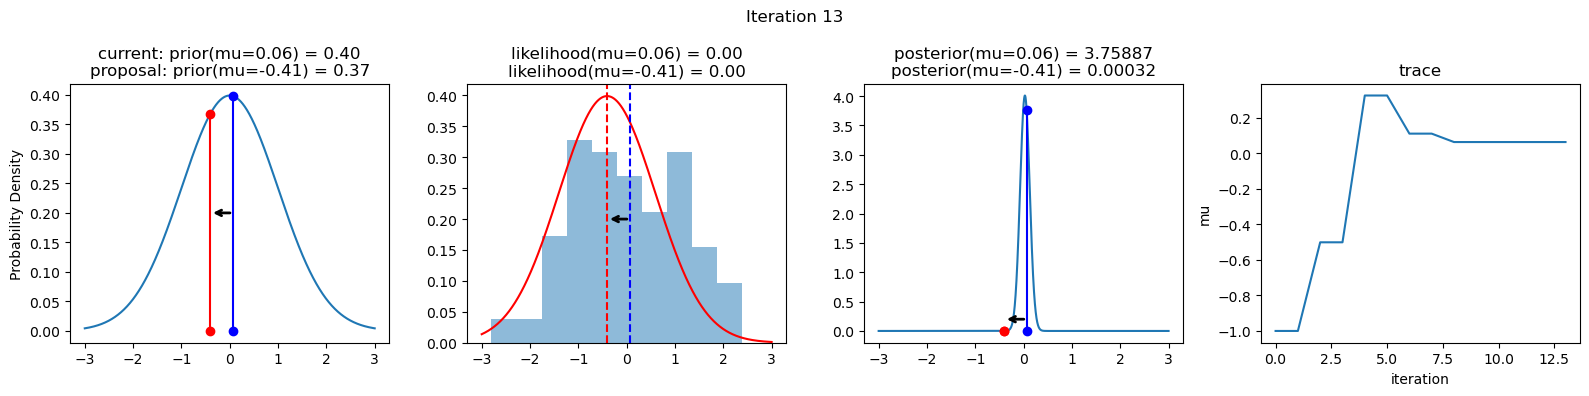

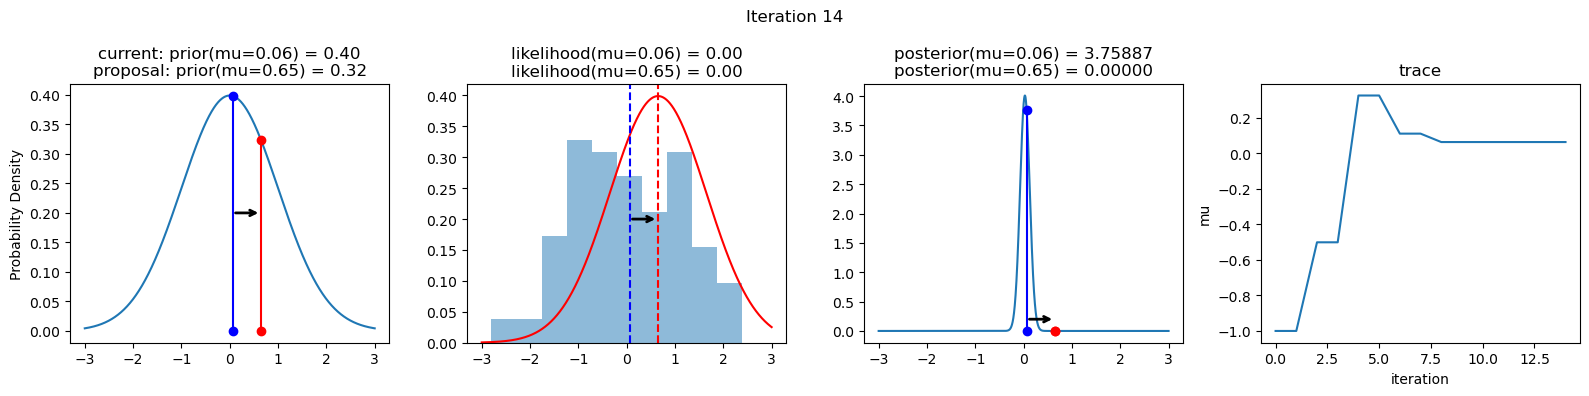

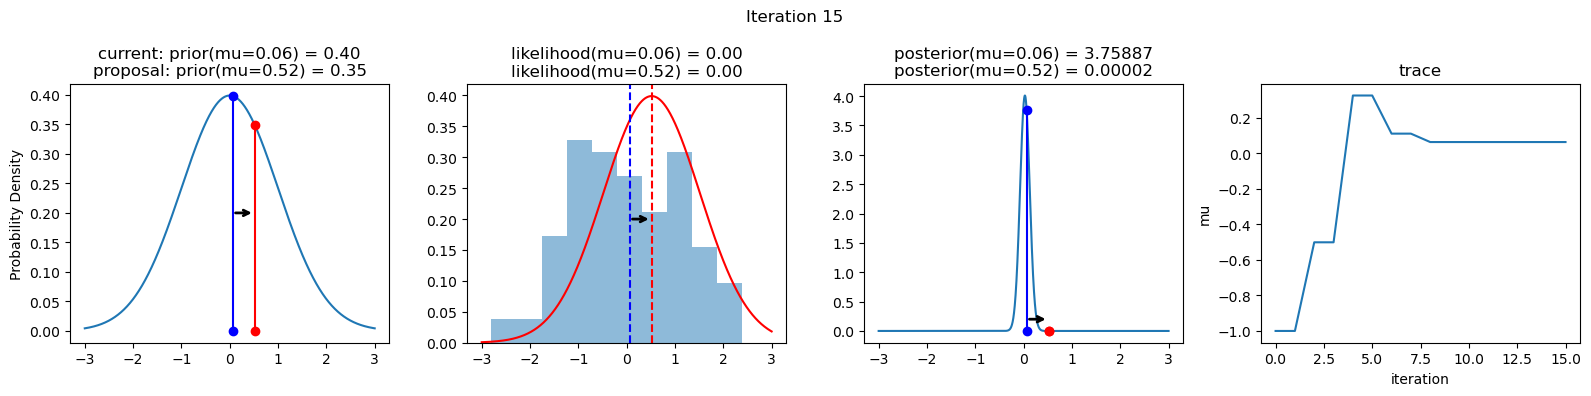

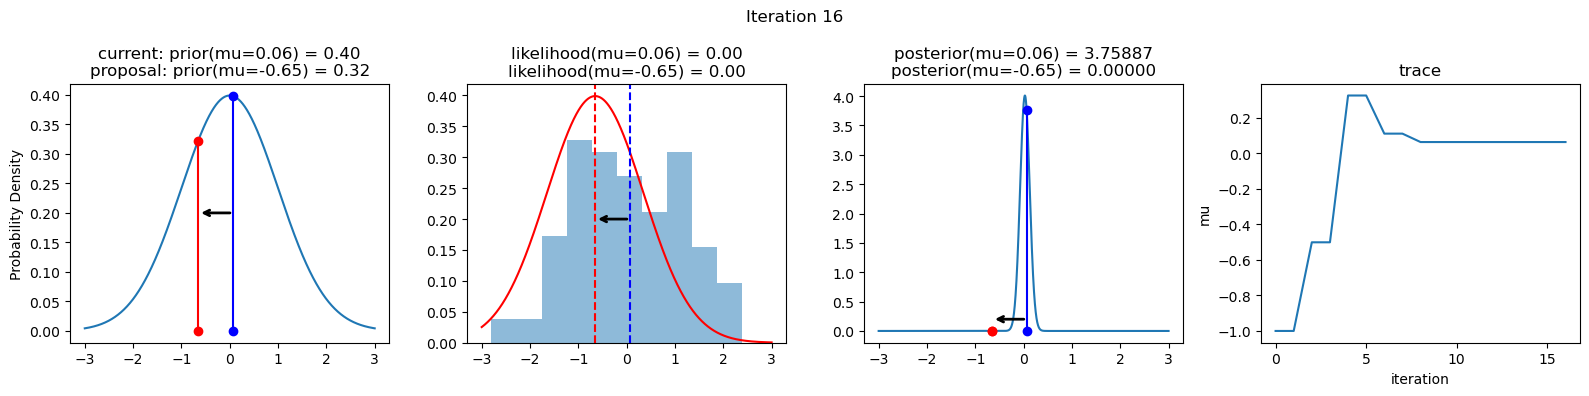

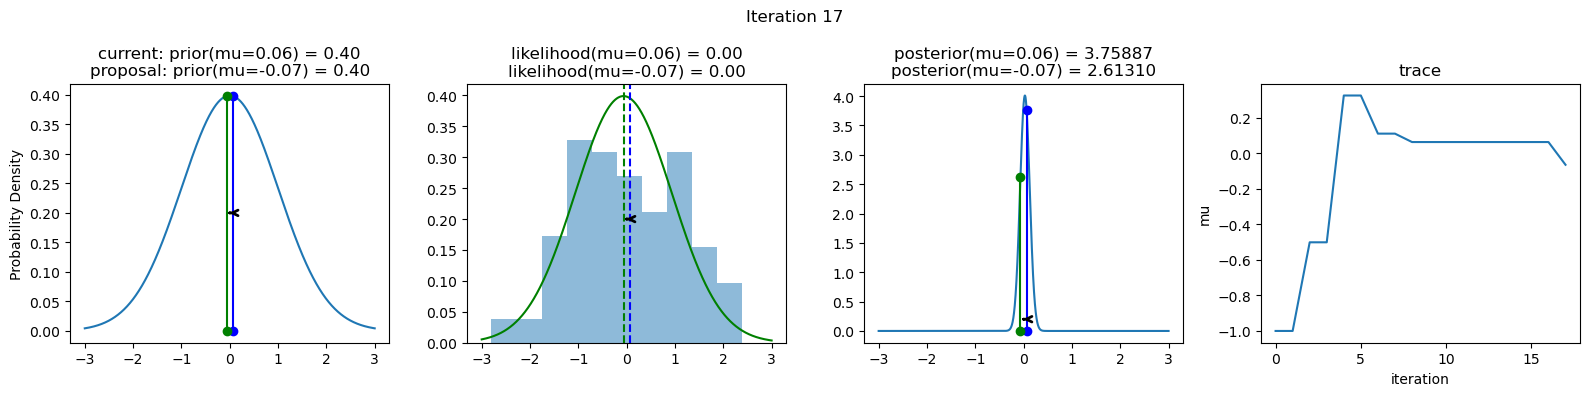

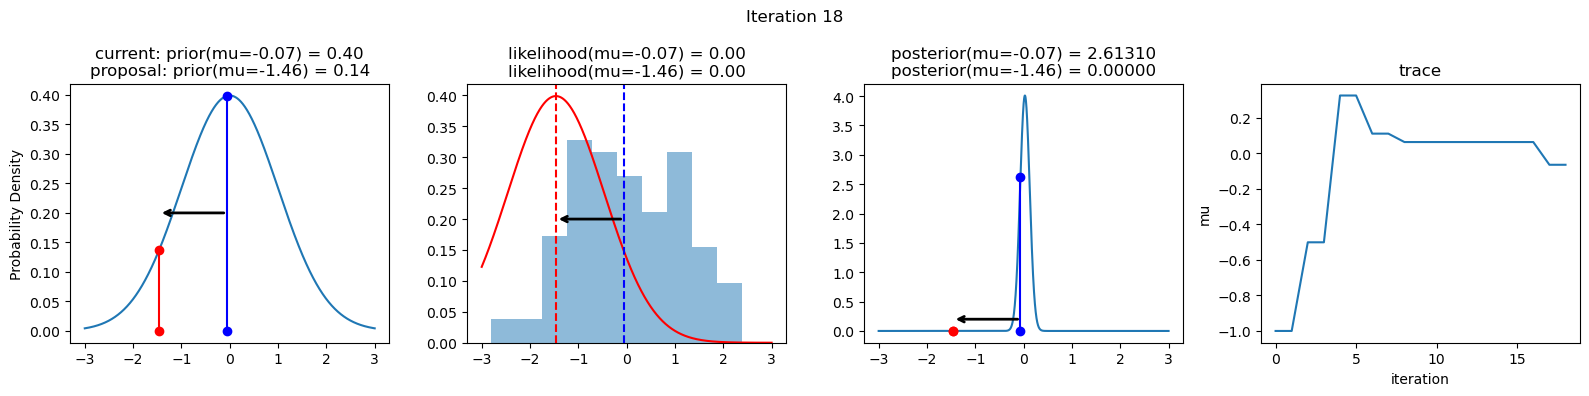

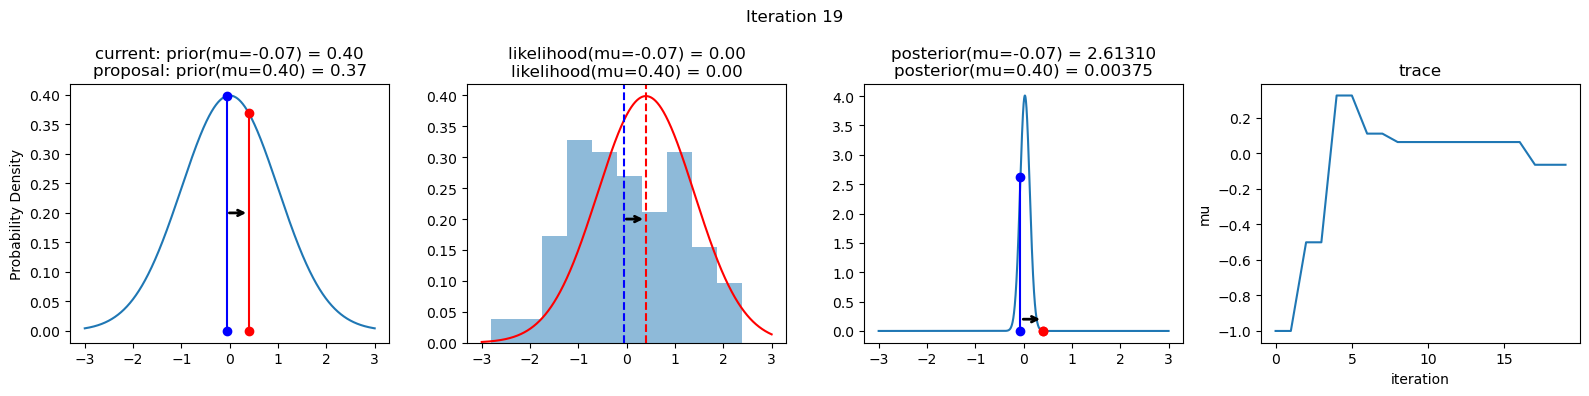

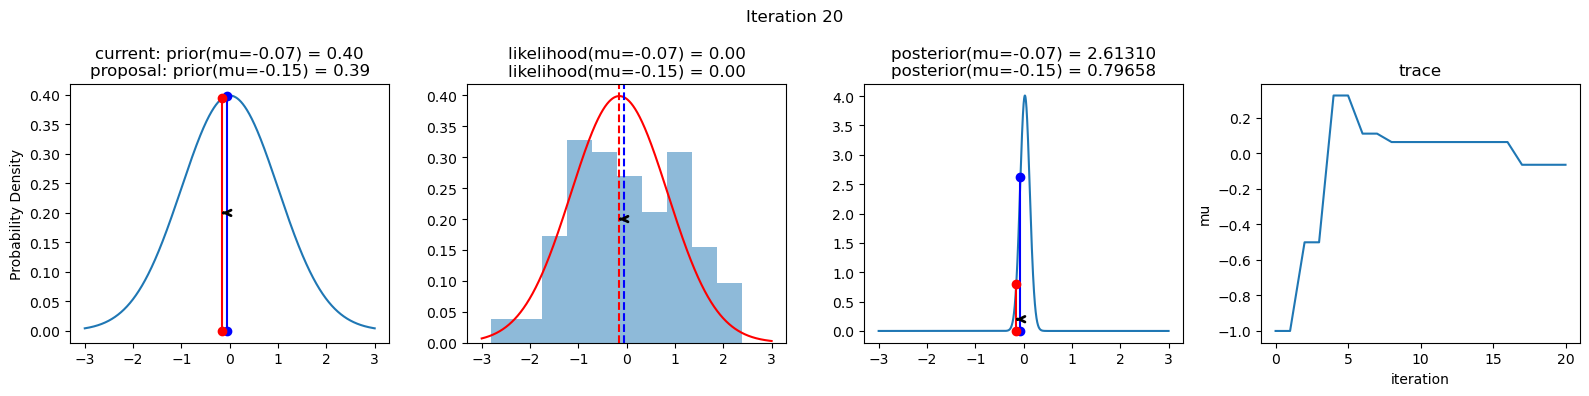

In [4]:
np.random.seed(123)
sampler(data, samples=20, mu_init=-1., plot=True); # 8 Markov Chain Iterations
# Trace is the plot of the Markov Chain

What happens when we do this lots of times? You might need to wait for a minute. Consider this a lesson in that running MCMCs can sometimes feel like watching paint dry.

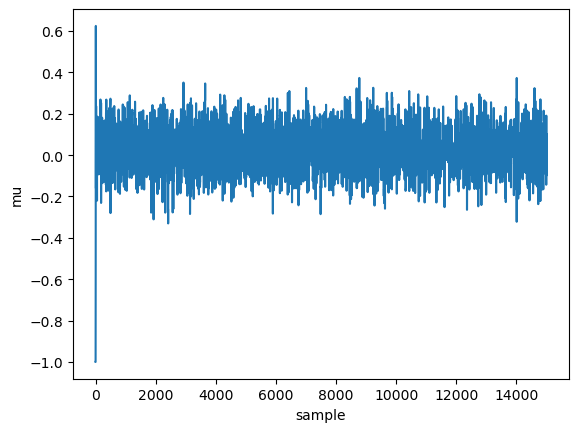

In [5]:
posterior = sampler(data, samples=15000, mu_init=-1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');
# Array of mu_i values from [1, 15000]

Making a histogram of these results is our estimated posterior probability distribution. Let's remove the first $500$ points as burn-in.

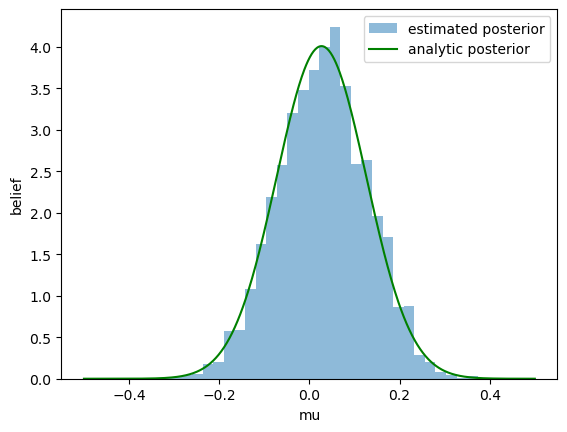

In [6]:
ax = plt.subplot()

burn = 500
ax.hist(posterior[burn:], bins=30, alpha=0.5, 
        density='True', label='estimated posterior')

xplot = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, xplot, 0, 1)
ax.plot(xplot, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');

ax.legend(fontsize=10);

We can compute the expected value of $\mu$, credible regions, and the MAP value.

In [7]:
# expected value
ex_mu = np.mean(posterior[burn:])

# 68% equal-tailed credible region
lower, upper = np.percentile(posterior[burn:],q=16), np.percentile(posterior[burn:],q=84)   

# MAP value
# many samplers output the likelihood x prior, 
# so it's usually than this
hist, bins = np.histogram(posterior[burn:], bins=30)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

print('Expected value of mu = ' + str(ex_mu))
print('68% credible region = ' + str(lower) + ' to ' + str(upper))
print('MAP value = ' + str(map_theta))

Expected value of mu = 0.03020600688872454
68% credible region = -0.06900963637695033 to 0.13171832140088893
MAP value = 0.05663910813105316


Our algorithm for deciding where to move next used a normal distribution where the mean was the current value and we assumed a width of 0.5. <font color='red'>Make this much smaller and much larger and see what it does to the sampling efficiency through the behavior of the traceplot.</font>

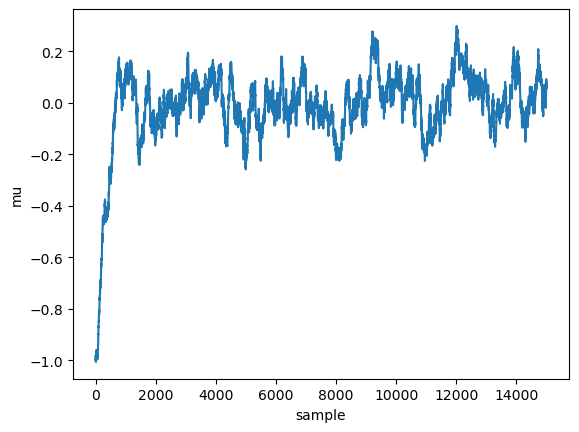

In [8]:
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=0.01)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

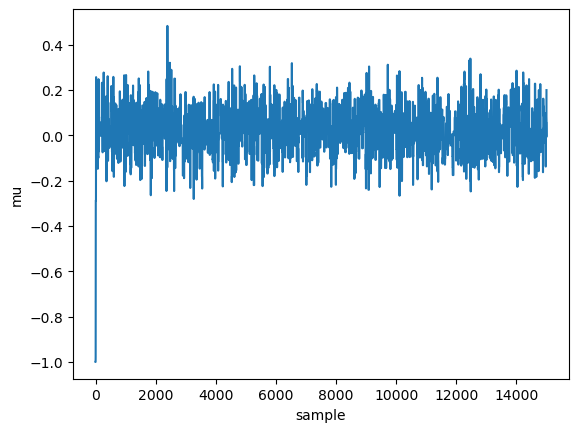

In [9]:
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=0.99)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

Ideally, our traceplot in each parameter would be **mixing well** (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. **The acceptance rate of new samples should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve**.

Take a look at these plots below for an arbitrary problem. The 1st column is the trace, the 2nd is the histogram of the chain, and the 3rd column is the acceptance rate of newly proposed samples. 

- **In the top row, the proposal width was too small**. The chain hardly moves, giving it a high acceptance rate but poor global exploration of the posterior surface.
- **In the middle row, the proposal width was too big**. The chain proposes new points that are far away from regions of high probability density, meaning that they're hardly ever accepted. The chain gets stuck.
- **Only the bottom row shows reasonable sampling. This is the Goldilocks scenario.**

![](figures/fig_taylor_mcmc.png)

### More Complex Models & Sophisticated Sampling

- The example you worked through above was overkill in that we were only trying to estmate $\mu$. Note also that we can do this in fewer than 10 lines using the ${\tt pymc3}$ module.


- The process is essentially the same when you add more parameters. Check out this [animation of a 2-D process](http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/) by the same author whose example we just followed.


- Also, check out [this](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=AdaptiveMH&target=multimodal) amazing visualization tool, and have some fun exploring the many different types of sampling algorithms. Metropolis-Hastings is only the start!


- In fact, the most basic type of MH algorithm could be **Adaptive Metropolis-Hastings**, where the proposal width updates itself in response to the currently-estimate covariance matrix of the MCMC chain. The chain learns how to optimize itself!! 


- We'll look at other algorithms and samplers in some time. There are plenty of tools that a professional astrophysicist can have in their toolbox to tackle research problems.